In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
import json
import torch
import yaml
import numpy as np
import cv2
import copy
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from nerfstudio.utils.eval_utils import eval_setup

/home/user/.local/lib/python3.10/site-packages/tinycudann/modules.py:31: UserWarning: System has multiple GPUs with different compute capabilities: [61, 52]. Using compute capability 52 for best compatibility. This may result in suboptimal performance.
  warnings.warn(


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
os.chdir('/workspace/plane-nerf')
MODEL_PATH = "/workspace/plane-nerf/outputs/jackal_floor_training_data_1/plane-nerf/2024-03-11_145657"
DATA_PATH = "/workspace/plane-nerf/data/jackal_floor_synthetic_data"

BACKGROUND_IMG = "/workspace/plane-nerf/data/background.png"
TRANSFORM_PATH = "/workspace/plane-nerf/data/jackal_floor_training_data_1/transforms.json"

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

if not os.path.exists(os.path.join(DATA_PATH, "images")):
    os.makedirs(os.path.join(DATA_PATH, "images"))

with open(TRANSFORM_PATH, "r") as f:
    transforms = json.load(f)
    
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, checkpoint_path, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )


tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Fal

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_floor_training_data_1/plane-nerf/2024-03-11_145657/nerfstudio_models/step-000009999.ckpt

Setting up training dataset...

Caching all 300 images.

torch.Size([720, 1280, 4])
torch.Size([720, 1280, 3])


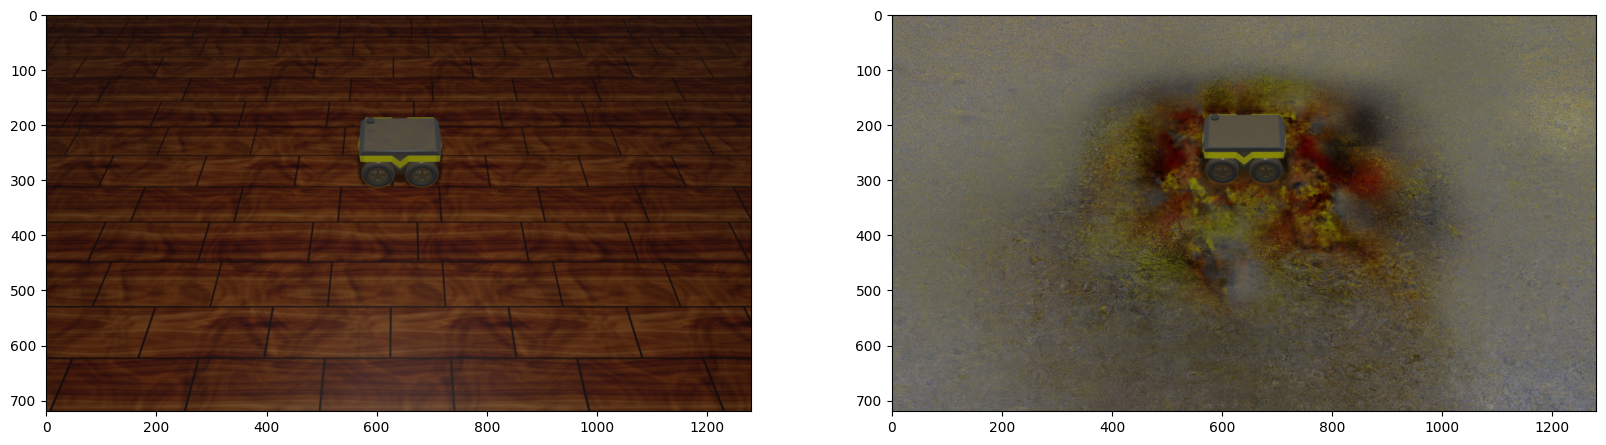

In [4]:
#Camera object: generate_ray command to create
#RayBundle object

pipeline.eval()
pipeline.datamanager.setup_train()

for camera, batch in pipeline.datamanager.fixed_indices_train_dataloader:
    outputs = pipeline.model.get_outputs_for_camera(camera=camera)    
    break

gt_rgb = batch["image"].to(pipeline.model.device)
predicted_rgb = outputs["rgb"]

print(gt_rgb.shape)
print(predicted_rgb.shape)

#Plot gt_rgb and predicted_rgb with matplotlib
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(gt_rgb.cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(predicted_rgb.cpu().numpy())
plt.show()

In [7]:
import random
from scipy.spatial.transform import Rotation
from plane_nerf.inerf_utils import transform_original_space_to_pose

z = 2.5
pitch = 0.785
total_frames = 300

fov = 0.8

all_frames = []

#Open background_img
background_img = cv2.imread(BACKGROUND_IMG)
background_img = cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB)
background = torch.tensor(background_img, dtype=torch.float32).to(pipeline.device) / 255.0

for cnt in range(total_frames):

    frame = {}
    
    r = np.random.uniform(2, 4)
    angle = np.random.uniform(0, 2*np.pi)
    turn = random.uniform(-fov/2,fov/2)

    start_transform_matrix = np.eye(4)
    start_transform_matrix[:3, :3] = Rotation.from_euler("xyz",[pitch, 0, turn]).as_matrix()
    start_transform_matrix[0, 3] = 0
    start_transform_matrix[1, 3] = -r
    start_transform_matrix[2, 3] = z

    rot = Rotation.from_euler("xyz",np.array([0, 0, angle])).as_matrix()
    rot_matrix = np.eye(4)
    rot_matrix[:3, :3] = rot
    transform_matrix = np.matmul(rot_matrix, start_transform_matrix)

    frame["transform_matrix"] = transform_matrix.tolist()

    #Get Footprint Mask
    pose = transform_matrix
    pose = pose[:3][:4]
    pose = np.array([pose])
    pose = torch.from_numpy(pose).float().to("cpu")

    pose = transform_original_space_to_pose(pose, 
                                            pipeline.datamanager.train_dataparser_outputs.dataparser_transform,
                                            pipeline.datamanager.train_dataparser_outputs.dataparser_scale,
                                            "opengl")
    
    print(pose)

    camera.camera_to_worlds = pose.to(pipeline.device)
    outputs = pipeline.model.get_outputs_for_camera(camera=camera)   
    rendered_img = outputs["rgb"]

    frame["file_path"] = "images/{}.png".format(cnt)

    #Save rendered_img
    rendered_img = rendered_img.squeeze(0).cpu().numpy()
    rendered_img = np.clip(rendered_img, 0, 1)
    rendered_img = (rendered_img * 255).astype(np.uint8)
    rendered_img = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(DATA_PATH, frame["file_path"]), rendered_img)

    all_frames.append(frame)
    
    print(frame)


tensor([[[ 5.1196e-01, -6.0765e-01,  6.0717e-01,  8.6115e-01],
         [ 8.5901e-01,  3.6216e-01, -3.6187e-01, -1.8747e-01],
         [-5.2000e-09,  7.0683e-01,  7.0739e-01,  0.0000e+00]]])
{'transform_matrix': [[0.511961142296092, -0.6076526124790476, 0.6071689149868176, 2.583452257129467], [0.8590086080935865, 0.362155306329695, -0.36186702712234525, -0.5624144219349122], [0.0, 0.7068251811053659, 0.7073882691671998, 2.5], [0.0, 0.0, 0.0, 1.0]], 'file_path': 'images/0.png'}
tensor([[[-3.4635e-01, -6.6360e-01,  6.6308e-01,  5.6756e-01],
         [ 9.3811e-01, -2.4500e-01,  2.4481e-01,  3.6367e-01],
         [-1.6066e-09,  7.0683e-01,  7.0739e-01,  0.0000e+00]]])
{'transform_matrix': [[-0.34634952535786273, -0.6636048550306702, 0.6630766189997244, 1.7026948873216066], [0.9381055411223104, -0.24500359126977964, 0.24480856598682893, 1.09101693812868], [0.0, 0.7068251811053657, 0.7073882691671993, 2.4999999999999996], [0.0, 0.0, 0.0, 1.0]], 'file_path': 'images/1.png'}
tensor([[[-9.0928e

In [8]:
transforms["frames"] = all_frames
with open(os.path.join(DATA_PATH,"transforms.json"), "w") as f:
    json.dump(transforms, f, indent=4)